In [12]:
# --- 1. Install necessary libraries ---
!pip install split-folders

# --- 2. Import all libraries ---
import os
import zipfile
import warnings
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from PIL import Image
import matplotlib.pyplot as plt
import splitfolders
from sklearn.metrics import classification_report

# --- 3. Configuration & Paths (Corrected from your screenshot) ---

# This name comes from your Kaggle UI (with a HYPHEN)
DATASET_NAME = 'actions-dataset' 

# --- Input Path (from Kaggle) ---
# This is the full, correct path to your class folders (e.g., 'looking_away')
# as shown in your screenshot
DATA_TO_SPLIT_DIR = f'/kaggle/input/{DATASET_NAME}/actions/' 

# --- Output Paths (where we write data) ---
OUTPUT_DIR = '/kaggle/working/'
# This is where we'll store the split (train/val/test) data
SPLIT_DATA_DIR = os.path.join(OUTPUT_DIR, 'dataset_split')

# --- Model Parameters ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30 # Max epochs (EarlyStopping will stop it sooner)

# --- Suppress warnings ---
warnings.filterwarnings('ignore')

print("All libraries imported and paths set.")
print(f"TensorFlow Version: {tf.__version__}")
print(f"✅ Source Data Path (Corrected): {DATA_TO_SPLIT_DIR}")
print(f"Split Data Output Dir: {SPLIT_DATA_DIR}")

All libraries imported and paths set.
TensorFlow Version: 2.18.0
✅ Source Data Path (Corrected): /kaggle/input/actions-dataset/actions/
Split Data Output Dir: /kaggle/working/dataset_split


In [13]:
print(f"Looking for data folders in: {DATA_TO_SPLIT_DIR}")
try:
    print(f"Found contents: {os.listdir(DATA_TO_SPLIT_DIR)}")
except Exception as e:
    print(f"Error listing directory: {e}")
    print("Please check your DATASET_NAME in Cell 1.")
    raise e

print(f"\nSplitting data from {DATA_TO_SPLIT_DIR}...")

# This one-line command does all the work!
splitfolders.ratio(
    DATA_TO_SPLIT_DIR, # <-- Use the direct input path
    output=SPLIT_DATA_DIR,
    seed=42,
    ratio=(0.8, 0.1, 0.1)  # 80% train, 10% val, 10% test
)

print("\nData splitting complete.")
print("--- New Split Data Structure ---")
print(os.listdir(SPLIT_DATA_DIR)) # Should show ['train', 'val', 'test']

Looking for data folders in: /kaggle/input/actions-dataset/actions/
Found contents: ['looking_away', 'raising_hand', 'sleeping', 'using_mobile', 'writing_notes']

Splitting data from /kaggle/input/actions-dataset/actions/...


Copying files: 15474 files [02:25, 106.58 files/s]


Data splitting complete.
--- New Split Data Structure ---
['test', 'train', 'val']


In [14]:
print("Setting up Data Augmentation and Generators...")

# Define our new data paths
TRAIN_DIR = os.path.join(SPLIT_DATA_DIR, 'train')
VAL_DIR = os.path.join(SPLIT_DATA_DIR, 'val')
TEST_DIR = os.path.join(SPLIT_DATA_DIR, 'test')

# 1. Training Data Augmentation (This adds diversity!)
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values
    
    # --- Augmentation Settings ---
    rotation_range=30,          # Randomly rotate
    width_shift_range=0.2,      # Randomly shift horizontally
    height_shift_range=0.2,     # Randomly shift vertically
    shear_range=0.2,            # "Slant" the image
    zoom_range=0.2,             # Randomly zoom in
    horizontal_flip=True,       # Randomly flip
    brightness_range=[0.8, 1.2],# Randomly change brightness
    fill_mode='nearest'
)

# 2. Validation/Test Data Generator (NO augmentation, just rescaling)
nontrain_datagen = ImageDataGenerator(rescale=1./255)

# 3. Create the Generators
print("Creating Training Generator...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical' 
)

print("Creating Validation Generator...")
validation_generator = nontrain_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False 
)

print("Creating Test Generator...")
test_generator = nontrain_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False 
)

# 4. Get class info
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
print(f"\nFound {num_classes} classes:")
print(class_names)

Setting up Data Augmentation and Generators...
Creating Training Generator...
Found 12377 images belonging to 5 classes.
Creating Validation Generator...
Found 1544 images belonging to 5 classes.
Creating Test Generator...
Found 1553 images belonging to 5 classes.

Found 5 classes:
['looking_away', 'raising_hand', 'sleeping', 'using_mobile', 'writing_notes']


In [15]:
print("Building model with MobileNetV2 base...")

# 1. Load the base model
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,  
    weights='imagenet'
)

# 2. Freeze the base model
base_model.trainable = False

# 3. Add our custom "head"
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False) 
x = GlobalAveragePooling2D()(x) 
x = Dropout(0.5)(x)             # <-- Key overfitting prevention step
x = Dense(128, activation='relu')(x) 
outputs = Dense(num_classes, activation='softmax')(x) # Final layer

model = Model(inputs, outputs)

print("Model built successfully.")

Building model with MobileNetV2 base...


I0000 00:00:1761756151.185178      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761756151.185955      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model built successfully.


In [16]:
print("Compiling model...")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Print a summary of our model's layers
model.summary()

Compiling model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [17]:
print("Starting training...")

# This callback will stop training if 'val_accuracy'
# doesn't improve for 5 epochs.
# It will also restore the model weights from the *best* epoch.
early_stopper = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_generator,
    epochs=EPOCHS, # This is the *max* epochs
    validation_data=validation_generator,
    callbacks=[early_stopper]
)

print("\nTraining complete!")

Starting training...
Epoch 1/30


I0000 00:00:1761756177.095386     150 service.cc:148] XLA service 0x7dc8b81126a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761756177.096593     150 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761756177.096617     150 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761756178.021321     150 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/387 ━━━━━━━━━━━━━━━━━━━━ 1:24:37 13s/step - accuracy: 0.2500 - loss: 2.8040

I0000 00:00:1761756182.893753     150 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


387/387 ━━━━━━━━━━━━━━━━━━━━ 273s 674ms/step - accuracy: 0.6821 - loss: 0.8765 - val_accuracy: 0.9922 - val_loss: 0.0504
Epoch 2/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 257s 663ms/step - accuracy: 0.9118 - loss: 0.2442 - val_accuracy: 0.9974 - val_loss: 0.0228
Epoch 3/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 243s 627ms/step - accuracy: 0.9401 - loss: 0.1709 - val_accuracy: 0.9929 - val_loss: 0.0326
Epoch 4/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 242s 625ms/step - accuracy: 0.9466 - loss: 0.1487 - val_accuracy: 0.9961 - val_loss: 0.0220
Epoch 5/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 243s 628ms/step - accuracy: 0.9601 - loss: 0.1119 - val_accuracy: 0.9916 - val_loss: 0.0244
Epoch 6/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 243s 627ms/step - accuracy: 0.9611 - loss: 0.1080 - val_accuracy: 0.9981 - val_loss: 0.0085
Epoch 7/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 244s 630ms/step - accuracy: 0.9696 - loss: 0.0914 - val_accuracy: 0.9968 - val_loss: 0.0147
Epoch 8/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 239s 618ms/step - accuracy: 0.9649 - loss: 0.10

Plotting training history...


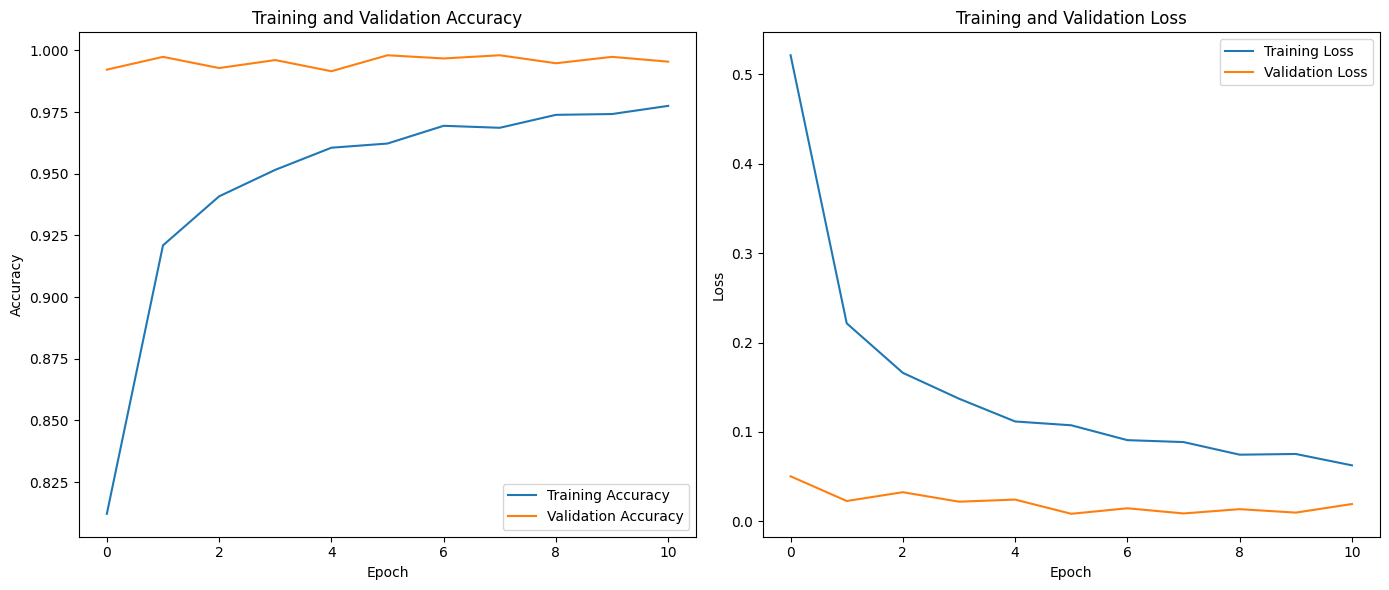

In [18]:
print("Plotting training history...")

# Get accuracy and loss from the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_ran = range(len(acc))

# --- Plot Accuracy ---
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_ran, acc, label='Training Accuracy')
plt.plot(epochs_ran, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# --- Plot Loss ---
plt.subplot(1, 2, 2)
plt.plot(epochs_ran, loss, label='Training Loss')
plt.plot(epochs_ran, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
print("Evaluating model on the unseen test set...")

# Evaluate the model
# This will return [loss, accuracy]
results = model.evaluate(test_generator)

print("\n--- Test Set Evaluation ---")
print(f"Test Loss:     {results[0]:.4f}")
print(f"Test Accuracy: {results[1]*100:.2f}%") # <-- This is your final number!

# --- Show a detailed Classification Report ---
print("\n--- Classification Report ---")

# Get predictions for the whole test set
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# Get true labels
y_true = test_generator.classes

# Print the report
print(classification_report(y_true, y_pred, target_names=class_names))

Evaluating model on the unseen test set...
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 327ms/step - accuracy: 0.9956 - loss: 0.0159

--- Test Set Evaluation ---
Test Loss:     0.0108
Test Accuracy: 99.74%

--- Classification Report ---
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 313ms/step
               precision    recall  f1-score   support

 looking_away       1.00      1.00      1.00       315
 raising_hand       1.00      0.99      0.99       296
     sleeping       1.00      1.00      1.00       306
 using_mobile       0.99      1.00      0.99       323
writing_notes       1.00      1.00      1.00       313

     accuracy                           1.00      1553
    macro avg       1.00      1.00      1.00      1553
 weighted avg       1.00      1.00      1.00      1553



In [20]:
# Save the model to the /kaggle/working/ directory
model_save_path = os.path.join(OUTPUT_DIR, 'my_action_classifier_final.h5')
model.save(model_save_path)

print(f"Model saved to: {model_save_path}")
print("You can download this file from the 'Data' > 'Output' tab on the right.")

Model saved to: /kaggle/working/my_action_classifier_final.h5
You can download this file from the 'Data' > 'Output' tab on the right.
